# Train the denoising models, and visualize the results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set True if you want to train. It will take around 30-60min.
# If it's false, it will only visualize the results loading the save checkpoints
TRAIN = False

In [3]:
from torch.utils.data import DataLoader
from DataLoader import AfricanWildlifeDataset, show_images
from DenoisingAE import DenoisingAE, DenoisingAEV1, DenoisingAEV2
from DenoisingResnet import DenoisingResnet
import torch
import gc
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from torchvision import transforms


checkpoints = {
    "gaussian": {
        0.1: {
            "v0": "denoising_checkpoints/gaussian/0.1/v0/best.ckpt",
            "v1": "denoising_checkpoints/gaussian/0.1/v1/best.ckpt",
            "v2": "denoising_checkpoints/gaussian/0.1/v2/best.ckpt",
            "resnet": "denoising_checkpoints/gaussian/0.1/resnet/best.ckpt",
        },
        0.2: {
            "v0": "denoising_checkpoints/gaussian/0.2/v0/best.ckpt",
            "v1": "denoising_checkpoints/gaussian/0.2/v1/best.ckpt",
            "v2": "denoising_checkpoints/gaussian/0.2/v2/best.ckpt",
            "resnet": "denoising_checkpoints/gaussian/0.2/resnet/best.ckpt",
        },
    },
    "bernoulli": {
        0.1: {
            "v0": "denoising_checkpoints/bernoulli/0.1/v0/best.ckpt",
            "v1": "denoising_checkpoints/bernoulli/0.1/v1/best.ckpt",
            "v2": "denoising_checkpoints/bernoulli/0.1/v2/best.ckpt",
            "resnet": "denoising_checkpoints/bernoulli/0.1/resnet/best2.ckpt",
        },
        0.3: {
            "v0": "denoising_checkpoints/bernoulli/0.3/v0/best.ckpt",
            "v1": "denoising_checkpoints/bernoulli/0.3/v1/best.ckpt",
            "v2": "denoising_checkpoints/bernoulli/0.3/v2/best.ckpt",
            "resnet": "denoising_checkpoints/bernoulli/0.3/resnet/best.ckpt",
        },
    },
}

torch.cuda.empty_cache()
gc.collect()

31

/home/edoardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/edoardo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


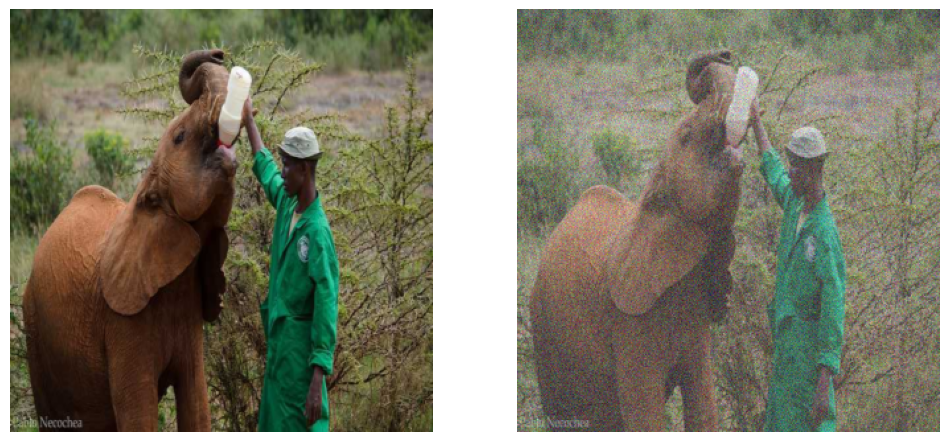

In [4]:
import gin

# Load the configuration file. This will load the dataset with the correct transform (the noise added)
# and the kind of denoising model to use. See config.cfg
gin.parse_config_file("config.cfg")

# The two types of dataset
train_dataset = AfricanWildlifeDataset()
val_dataset = AfricanWildlifeDataset(kind="valid")

# The models
ae = DenoisingAE()
resnet = DenoisingResnet()

# Just show an example of the noise (can be change in "config.cfg").
# The dataset returns both the noisy version and the original
noised, original = train_dataset[888]

show_images(original, noised)

In [5]:
# The loaders. I have 20 threads so I increased the number of workers a lot
train_loader = DataLoader(dataset=train_dataset, batch_size=4, num_workers=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

# Train

In [6]:
# Model to train

# model_to_train = DenoisingResnet()
model_to_train = DenoisingAEV1()

In [7]:
%%capture
if TRAIN:
    torch.set_float32_matmul_precision("medium")
    logger = TensorBoardLogger("tb_logs", name=f"denoising_autoencoder_{model_to_train.kind}")

    checkpoint_callback = ModelCheckpoint(save_top_k=1, save_last=True, monitor="val_loss")

    trainer = Trainer(logger=logger, max_epochs=150, callbacks=[checkpoint_callback])

    trainer.fit(model=model_to_train, train_dataloaders=train_loader, val_dataloaders=val_loader)
%%capture

# Examples of cleaned images

In [8]:
# Helper to apply the denoising model
def test_on_image(img, kind, noise_type, noise_value):
    if kind == "v1":
        # Need to call the class instance to load the checkpoint
        model = DenoisingAEV1
    elif kind == "v2":
        model = DenoisingAEV2
    elif kind == "v0":
        model = DenoisingAE
    else:
        model = DenoisingResnet
    loaded = model.load_from_checkpoint(checkpoints[noise_type][noise_value][kind])
    assert loaded.kind == kind

    return loaded(img.to("cuda"))

Plot the Autoencoders and Resnet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


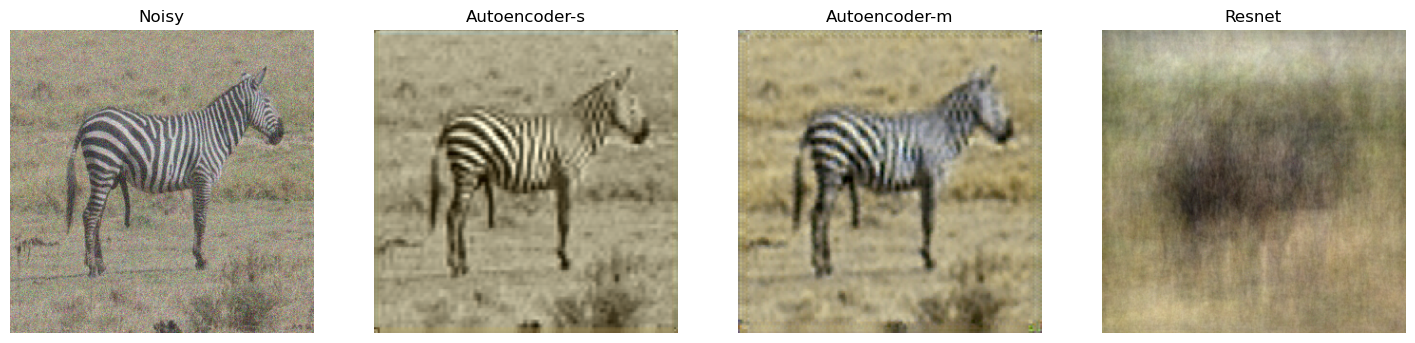

In [9]:
# IMage to show
img_to_pick = 0
# Noise type and parameter (be careful: set them at the exact values of thos in config.cfg)
noise_value = 0.1
noise_type = "gaussian"

# Retrieve the noisy image
noisy_img, _ = val_dataset[img_to_pick]
decodedv0 = test_on_image(noisy_img, "v0", noise_type, noise_value)
decodedv1 = test_on_image(noisy_img, "v1", noise_type, noise_value)

# Need to set the transforms to 320 or resnet won't work
val_dataset.transform.transforms[0] = transforms.Resize((320, 320))
decodedv2 = test_on_image(noisy_img, "resnet", noise_type, noise_value)
show_images(
    noisy_img,
    decodedv0.detach().cpu(),
    decodedv1.detach().cpu(),
    decodedv2.detach().cpu()[0],
    tags=["Noisy", "Autoencoder-s", "Autoencoder-m", "Resnet"],
)